In [78]:
#
# Logistic Regression (LR) II
#
# * Variable ranking/model selection
# * Model interpretation (again)
# * Intro (albeit very brief) to penalized and nonparametric LR models
# * Assessing performance via ROC and calibration curves
#

In [79]:
# Install required package(s)
pkgs <- c("car", "corrplot", "earth", "faraway", "glmnet", "ggplot2", "Hmisc", "plotmo", "pdp", "pROC", "rms", "vip")
lib <- installed.packages()[, "Package"]
install.packages(setdiff(pkgs, lib))

In [80]:
# Load Wisconsin breast cancer data set from faraway package
data(wcgs, package = "faraway")

head(wcgs)  # print first few records

,age,height,weight,sdp,dbp,chol,behave,cigs,dibep,chd,typechd,timechd,arcus
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>
1,49,73,150,110,76,225,A2,25,A,no,none,1664,absent
2,42,70,160,154,84,177,A2,20,A,no,none,3071,present
3,42,69,160,110,78,181,B3,0,B,no,none,3071,absent
4,41,68,152,124,78,132,B4,20,B,no,none,3064,absent
5,59,70,150,144,86,255,B3,20,B,yes,infdeath,1885,present
6,44,72,204,150,90,182,B4,0,B,no,none,3102,absent


In [81]:
?faraway::wcgs

In [ ]:
###############################################################################
#
# Model selection based on p-values
#
###############################################################################

In [82]:
# Fit an additive logistic regression model (i.e., no interaction effects)
lr.fit <- glm(chd ~ height + cigs, family = binomial(link = "logit"), data = wcgs)

# Print a summary of the fitted model
summary(lr.fit)


Call:
glm(formula = chd ~ height + cigs, family = binomial(link = "logit"), 
    data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0041  -0.4425  -0.3630  -0.3499   2.4357  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.50161    1.84186  -2.444   0.0145 *  
height       0.02521    0.02633   0.957   0.3383    
cigs         0.02313    0.00404   5.724 1.04e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1781.2  on 3153  degrees of freedom
Residual deviance: 1749.0  on 3151  degrees of freedom
AIC: 1755

Number of Fisher Scoring iterations: 5


In [69]:
# Fit a reduced model by dropping the term for height
lr.fit.reduced <- glm(chd ~ cigs, family = binomial(link = "logit"), data = wcgs)

# Compare full model to reduced model; what null hypothesis is implied here?
anova(lr.fit.reduced, lr.fit)#, test = "Chi")

,Resid. Df,Resid. Dev,Df,Deviance
,<dbl>,<dbl>,<dbl>,<dbl>
1,3152,1749.969,NA,NA
2,3151,1749.049,1,0.9202473


In [73]:
# I don't think drop1() or add1() are very useful; see ?drop1 for further details
drop1(lr.fit, test = "Chi")

,Df,Deviance,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,1749.049,1755.049,NA,NA
height,1,1749.969,1753.969,0.9202473,3.374101e-01
cigs,1,1780.119,1784.119,31.0695040,2.489521e-08


In [64]:
# Compute AIC directly
c("AIC (full)" = AIC(lr.fit), "AIC (reduced)" = AIC(lr.fit.reduced))

AIC (full) AIC (reduced) 
     1755.049      1753.969

In [ ]:
# Problems with the p-value approach:
#
# * Not what inference was designed for
# * Does not take into account multiple testing issue

In [ ]:
###############################################################################
#
# Let's look at some effect plots using various packages...
#
###############################################################################

 plotmo grid:    height cigs
                     70    0


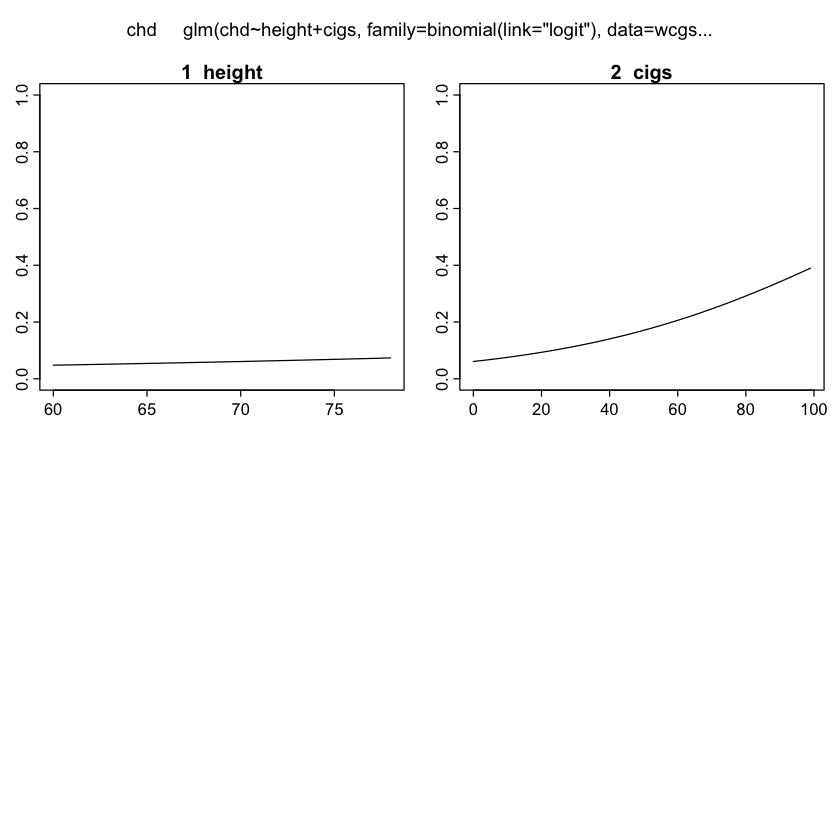

In [74]:
# The plotmo package
plotmo::plotmo(lr.fit)

In [ ]:
library(ggplot2)
library(pdp)

# Set theme for ggplot2 graphics
theme_set(theme_bw())

# These plots will be linear on the logit scale (why?) but nonlinear on the probability scale 
partial(lr.fit, pred.var = "cigs", prob = TRUE, plot = TRUE, rug = TRUE,
        plot.engine = "ggplot2") +
  geom_rug(data = wcgs, aes(x = cigs), alpha = 0.2, inherit.aes = FALSE)  # why add this?

In [ ]:
# Easy enough to do by hand; here, we're plotting the predicted probability of 
# developing CHD as a function of cigs while holding height constant at its 
# median value (i.e., 70 inches)
newd <- data.frame("cigs" = 0:99, height = 70)
prob <- predict(lr.fit, newdata = newd, type = "response")
plot(newd$cigs, prob, type = "l", lty = 1, las = 1, 
     xlab = "Number of cigarettes smoked per day", 
     ylab = "Conditional probabiluty of CHD")

In [ ]:
###############################################################################
#
# Variable (i.e., model) selection without p-values
#
# Note: Pr(selecting the "right" subset of features | data) = 0
#
###############################################################################

In [75]:
lr.fit.all <- glm(chd ~ ., family = binomial(link = "logit"), data = wcgs)#, maxit = 9999)

Warning message:
“glm.fit: algorithm did not converge”


In [76]:
# Notice anything?
summary(lr.fit.all)


Call:
glm(formula = chd ~ ., family = binomial(link = "logit"), data = wcgs)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-2.409e-06  -2.409e-06  -2.409e-06  -2.409e-06   2.409e-06  

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error z value Pr(>|z|)
(Intercept)      2.657e+01  2.228e+05   0.000    1.000
age             -6.021e-14  1.208e+03   0.000    1.000
height          -1.314e-13  3.067e+03   0.000    1.000
weight           1.866e-14  3.832e+02   0.000    1.000
sdp              2.085e-14  6.738e+02   0.000    1.000
dbp             -3.013e-14  1.068e+03   0.000    1.000
chol            -3.390e-16  1.524e+02   0.000    1.000
behaveA2        -2.937e-13  2.413e+04   0.000    1.000
behaveB3        -2.583e-14  2.444e+04   0.000    1.000
behaveB4         1.605e-13  2.937e+04   0.000    1.000
cigs            -8.704e-15  4.526e+02   0.000    1.000
dibepB                  NA         NA      NA       NA
typechd

In [83]:
# What (potentially) happened?

# Let's inspect the data a bit more; we'll start with a SPLOM
y <- ifelse(wcgs$chd == "yes", 1, 0)
palette("Okabe-Ito")
pairs(wcgs, col = adjustcolor(y + 1, alpha.f = 0.1))
palette("default")  # back to default color pal

In [84]:
# Which columns contain missing values?
sapply(wcgs, FUN = function(column) mean(is.na(column)))

age       height       weight          sdp          dbp         chol 
0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0038046925 
      behave         cigs        dibep          chd      typechd      timechd 
0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000 
       arcus 
0.0006341154

In [85]:
# Look at correlations between numeric features
num <- sapply(wcgs, FUN = is.numeric)  # identify numeric columns
(corx <- cor(wcgs[, num], use = "pairwise.complete.obs"))  # simple correlation matrix

,age,height,weight,sdp,dbp,chol,cigs,timechd
age,1.000000000,-0.095375682,-0.034404537,0.16574640,0.13919776,0.089188510,-0.005033852,-0.070919630
height,-0.095375682,1.000000000,0.532935466,0.01837357,0.01027555,-0.088937779,0.014911292,-0.009895169
weight,-0.034404537,0.532935466,1.000000000,0.25324962,0.29592019,0.008537442,-0.081747507,-0.065350046
sdp,0.165746397,0.018373573,0.253249623,1.00000000,0.77290641,0.123061297,0.029977529,-0.107884203
dbp,0.139197757,0.010275549,0.295920186,0.77290641,1.00000000,0.129597108,-0.059342317,-0.110693969
chol,0.089188510,-0.088937779,0.008537442,0.12306130,0.12959711,1.000000000,0.096031834,-0.095390054
cigs,-0.005033852,0.014911292,-0.081747507,0.02997753,-0.05934232,0.096031834,1.000000000,-0.093933141
timechd,-0.070919630,-0.009895169,-0.065350046,-0.10788420,-0.11069397,-0.095390054,-0.093933141,1.000000000


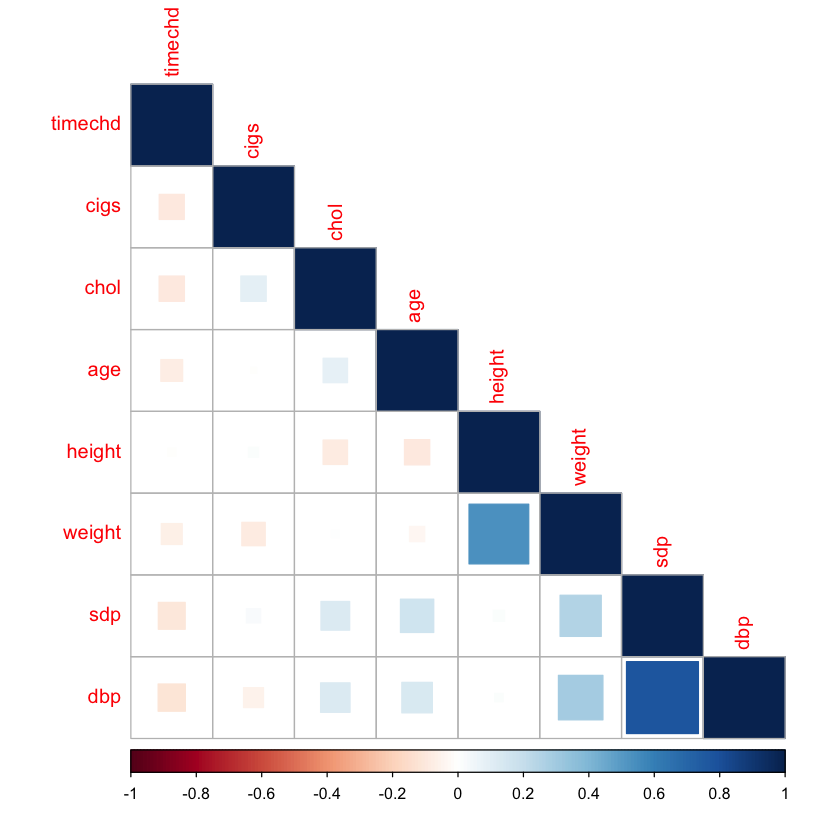

In [86]:
# Visualize correlations; can be useful if you have a lot of features
corrplot::corrplot(corx, method = "square", order = "FPC", type = "lower", diag = TRUE)

In [ ]:
# What about categorical features?
xtabs(~ behave + dibep, data = wcgs)  # perfect correlation?

In [ ]:
# Redunancy analysis (but first remove response and leakage predictors)
Hmisc::redun(~ ., nk = 0, data = subset(wcgs, select = -c(chd, typechd, timechd)))

In [ ]:
?Hmisc::redun

In [88]:
# Refit model without leakage or redundant features
summary(lr.fit.all <- glm(chd ~ . - typechd - timechd - dibep, family = binomial(link = "logit"), data = wcgs))


Call:
glm(formula = chd ~ . - typechd - timechd - dibep, family = binomial(link = "logit"), 
    data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3653  -0.4362  -0.3128  -0.2208   2.8603  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -12.331126   2.350347  -5.247 1.55e-07 ***
age            0.061812   0.012421   4.977 6.47e-07 ***
height         0.006903   0.033335   0.207  0.83594    
weight         0.008637   0.003892   2.219  0.02647 *  
sdp            0.018146   0.006435   2.820  0.00481 ** 
dbp           -0.000916   0.010903  -0.084  0.93305    
chol           0.010726   0.001531   7.006 2.45e-12 ***
behaveA2       0.082920   0.222909   0.372  0.70990    
behaveB3      -0.618013   0.245032  -2.522  0.01166 *  
behaveB4      -0.487224   0.321325  -1.516  0.12944    
cigs           0.021036   0.004298   4.895 9.84e-07 ***
arcuspresent   0.212796   0.143915   1.479  0.13924    
---
Signif. codes:  0 ‘***’ 0.00

In [ ]:
# 1. What about dbp and sbp, aren't they highly correlated? 
# 2. Does multcollinearity seem to be causing issues? 

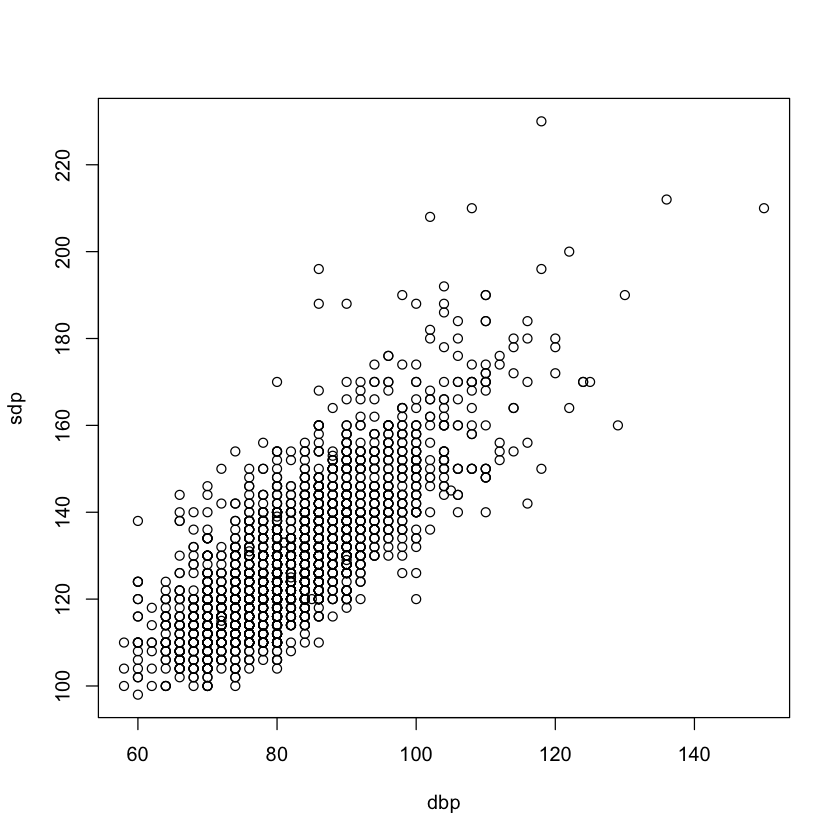

In [89]:
plot(sdp ~ dbp, data = wcgs)

In [ ]:
# Check (generalized) variance inflation factors (VIFs)
car::vif(lr.fit.all)

In [ ]:
summary(lr.fit.all)

In [90]:
summary(lr.fit.all <- update(lr.fit.all, formula = . ~ . - sdp))


Call:
glm(formula = chd ~ age + height + weight + dbp + chol + behave + 
    cigs + arcus, family = binomial(link = "logit"), data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2908  -0.4385  -0.3165  -0.2218   2.9560  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -12.041972   2.344264  -5.137 2.79e-07 ***
age            0.065303   0.012322   5.300 1.16e-07 ***
height         0.005524   0.033290   0.166  0.86821    
weight         0.008804   0.003912   2.250  0.02442 *  
dbp            0.022216   0.007091   3.133  0.00173 ** 
chol           0.010775   0.001518   7.097 1.28e-12 ***
behaveA2       0.133768   0.222417   0.601  0.54755    
behaveB3      -0.578278   0.244802  -2.362  0.01817 *  
behaveB4      -0.455897   0.321158  -1.420  0.15574    
cigs           0.022303   0.004261   5.235 1.65e-07 ***
arcuspresent   0.212350   0.143615   1.479  0.13924    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

In [ ]:
# How to measure relative influence/importance of each feature?
#
# A (very) crude way in an additive GzLM is to look at the absolute 
# value of the associated test statistics or standardized coefficients
vip::vi(lr.fit.all)  # see ?vip::vi for details

In [ ]:
# Leave-one-covariate-out (LOCO) approach; similar to (but better than) permutation importance
#
# Note: Would be better to incorporate some form of cross-validation (or bootstrap)
xnames <- setdiff(names(wcgs), c("chd", "typechd", "timechd", "dibep", "sdp"))  # predictors only
vi.scores <- numeric(length(xnames))
names(vi.scores) <- xnames
(baseline <- deviance(lr.fit.all))  # smaller is better; could also use AUC, Brier score, etc.
for (xname in xnames) {
  data.copy <- subset(wcgs, select = -c(typechd, timechd, dibep))
  data.copy[[xname]] <- NULL
  fit.new <- glm(chd ~ ., data = data.copy, family = binomial(link = "logit"))
  vi.scores[xname] <- deviance(fit.new) - baseline  # measure drop in performance
}
sort(vi.scores, decreasing = TRUE)
barplot(sort(vi.scores, decreasing = TRUE), cex.names = 0.8)

In [91]:
# Variable selection using backward elimination with AIC; which variables were dropped?
summary(lr.fit.back <- MASS::stepAIC(lr.fit.all, direction = "backward", trace = 0))


Call:
glm(formula = chd ~ age + weight + dbp + chol + behave + cigs + 
    arcus, family = binomial(link = "logit"), data = wcgs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2897  -0.4380  -0.3161  -0.2219   2.9554  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -11.691116   1.009395 -11.582  < 2e-16 ***
age            0.065167   0.012293   5.301 1.15e-07 ***
weight         0.009166   0.003244   2.826  0.00472 ** 
dbp            0.022019   0.006992   3.149  0.00164 ** 
chol           0.010750   0.001511   7.115 1.12e-12 ***
behaveA2       0.134135   0.222408   0.603  0.54644    
behaveB3      -0.578433   0.244800  -2.363  0.01813 *  
behaveB4      -0.455984   0.321150  -1.420  0.15565    
cigs           0.022366   0.004243   5.271 1.35e-07 ***
arcuspresent   0.213639   0.143407   1.490  0.13629    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

In [ ]:
# Variable selection using forward selection with AIC; which variables were added?
m <- glm(chd ~ cigs, data = subset(wcgs, select = -c(typechd, timechd, dibep)), 
         family = binomial(link = "logit"))
(lr.fit.forward <- MASS::stepAIC(m, direction = "forward", trace = 0))

In [ ]:
add1(m, scope = ~ height + weight)

Loading required package: Matrix

Loaded glmnet 4.1-7



[1] 3140   13

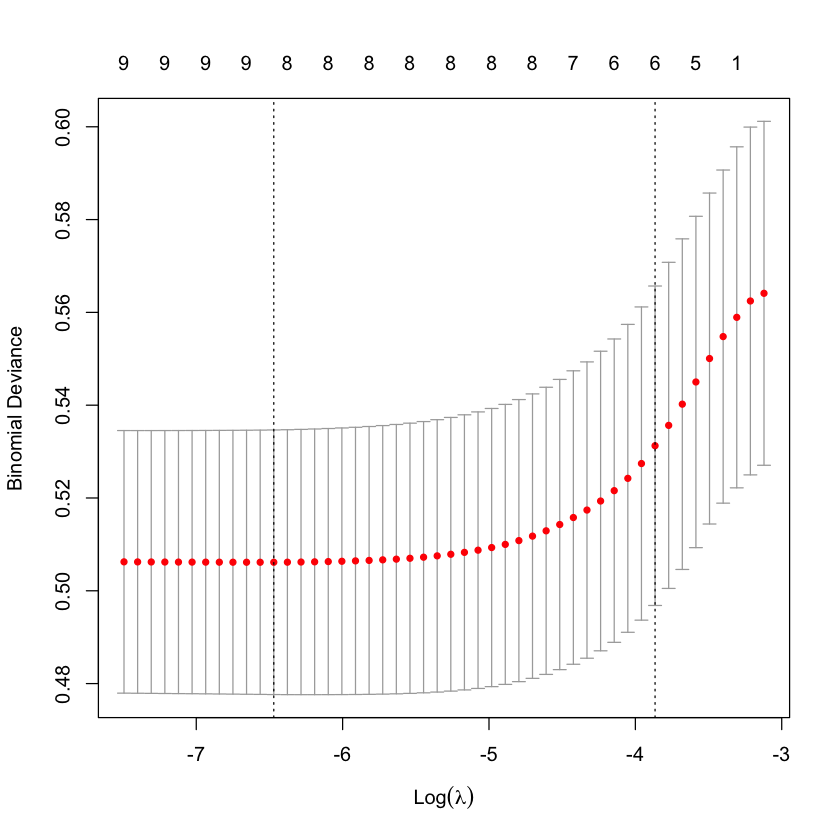

In [92]:
# 
# * glmnet fits elastic net (ENET) model paths for some generalized linear models (GLMs)
#
# * Essentially, ENET = ridge regression + LASSO (or L1 penalty + L2 penalty)
#
#   - The ridge part helps deal with multicollinearity (more stable coefficients)
#   - The LASSO part helps with variable selection
#
# * See Section 6.2 of ISL book: https://hastie.su.domains/ISLR2/ISLRv2_website.pdf (FREE!!)
#
# * From my HOMLR book with Brad: https://bradleyboehmke.github.io/HOML/regularized-regression.html (FREE!!)
# 
# * Intro videos: https://www.dataschool.io/15-hours-of-expert-machine-learning-videos/
#
library(glmnet)

# Fit an elastic net model (i.e., LASSO and ridge penalties) using 5-fold CV
dim(wcgs.complete <- na.omit(wcgs))
X <- model.matrix(~. - chd - typechd - timechd - behave - 1 , data = wcgs.complete)
lr.enet <- cv.glmnet(X, y = ifelse(wcgs.complete$chd == "yes", 1, 0), family = "binomial", nfold = 5,
                    keep = TRUE)
plot(lr.enet)

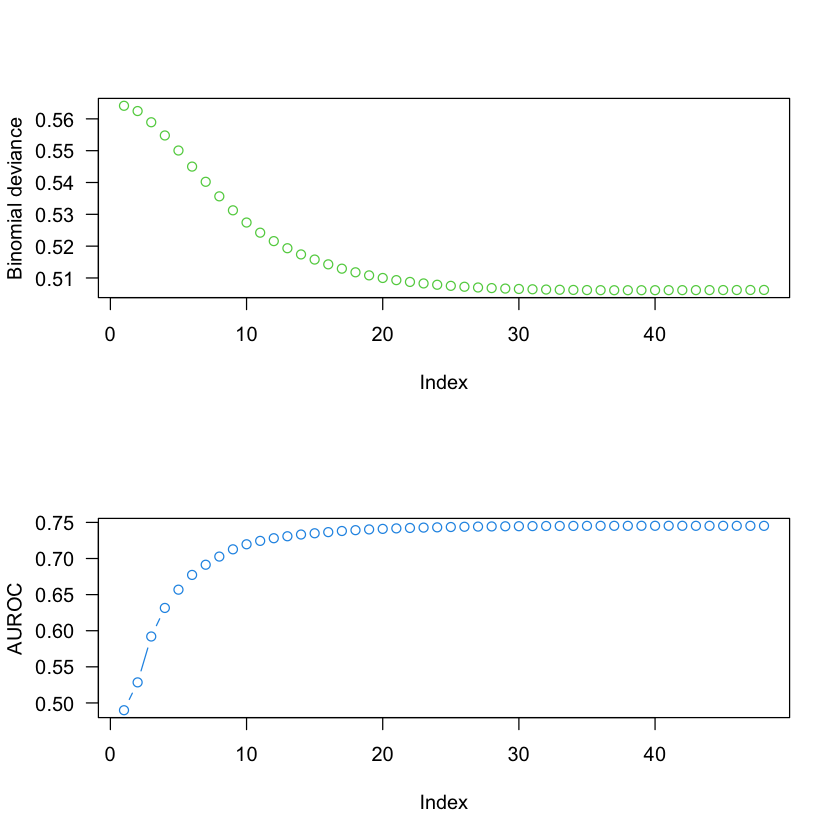

In [93]:
# Compute cross-validated performance measures
perf <- assess.glmnet(lr.enet$fit.preval, 
                      newy = ifelse(wcgs.complete$chd == "yes", 1, 0),
                      family = "binomial")

# Plot results
par(mfrow = c(2, 1))
#plot(perf$mse, type = "b", ylab = "MSE (i.e., Brier score)", col = 2)
plot(perf$deviance, type = "b", ylab = "Binomial deviance", col = 3, las = 1)
plot(perf$auc, type = "b", ylab = "AUROC", col = 4, las = 1)

In [ ]:
# Inspect coefficients from three fits
coef(lr.fit.back)
round(cbind(coef(lr.enet, s = "lambda.1se"), coef(lr.enet, s = "lambda.min")), digits = 5)

In [94]:
#
# For kicks, let's try a nonparammetric logistic regression model via the
# *multivariate adaptive regression splines* (MARS) algorithm; think of MARS
# as an automatic *generalized linear model* (GLM) that will try to find useful
# transformations and interaction effects to include.
#
# Some sueful resources:
#
#   * Mine and Brad's slides from a two-day machine learning workshop for Analytics Connect '18
#     https://koalaverse.github.io/AnalyticsSummit18/04-MARS.html#1
#
#   * earth package vignette: http://www.milbo.org/doc/earth-notes.pdf
#
library(earth)

# Fit a degree-2 MARS model (i.e., allow up to 2-way interaction effects)
lr.mars <- earth(chd ~ . - typechd - timechd - behave - sdp, data = na.omit(wcgs), 
                 degree = 2, glm = list(family = binomial))

# Print summary of model fit
summary(lr.mars)

Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix

Loading required package: TeachingDemos



Call: earth(formula=chd~.-typechd-timechd-behave-sdp, data=na.omit(wcgs),
            glm=list(family=binomial), degree=2)

GLM coefficients
                                    yes
(Intercept)                 -1.76699612
h(age-42)                    0.19935137
h(245-weight)                0.05454156
h(364-chol)                 -0.00992654
h(chol-364)                  0.16223325
h(60-cigs)                  -0.02496502
h(age-42) * dibepB          -0.06886581
h(age-42) * h(185-weight)   -0.00156440
h(age-42) * h(110-dbp)      -0.00285367
h(226-weight) * h(364-chol) -0.00067032
h(weight-226) * h(364-chol)  0.00036179
h(245-weight) * h(294-chol)  0.00045115
h(308-chol) * h(60-cigs)     0.00001614
h(chol-308) * h(60-cigs)    -0.00208908

GLM (family binomial, link logit):
 nulldev   df       dev   df   devratio     AIC iters converged
 1769.17 3139   1550.13 3126      0.124    1578     6         1

Earth selected 14 of 20 terms, and 6 of 8 predictors
Termination condition: Reached nk 21
Impo

In [ ]:
plot(lr.mars)  # not terribly useful

In [ ]:
library(vip)

# Variable importance plots
vip1 <- vip(lr.fit.all, geom = "point", include_type = TRUE)
vip2 <- vip(lr.mars, geom = "point", include_type = TRUE)  # see ?vip::vi_model for details
gridExtra::grid.arrange(vip1, vip2, nrow = 1)

In [ ]:
# Look at a PD plot of age
pd1 <- partial(lr.mars, pred.var = "cigs", plot = TRUE, plot.engine = "ggplot2", rug = TRUE) + ggtitle("Logit scale")
pd2 <- partial(lr.mars, pred.var = "cigs", plot = TRUE, prob = TRUE, plot.engine = "ggplot2", rug = TRUE) + ggtitle("Probability scale")
gridExtra::grid.arrange(pd1, pd2, nrow = 1)

In [ ]:
hist(wcgs$chol, 50)

In [ ]:
###############################################################################
#
# Assessing performance
#
###############################################################################

In [97]:
# Confusion matrix (i.e., 2x2 contingency table of classification results)
y <- na.omit(wcgs)$chd  # observed classes
prob <- predict(lr.fit.back, type = "response")  # predicted probabilities
classes <- ifelse(prob > 0.5, "yes", "no")  # classification based on 0.5 threshold
(cm <- table("actual" = y, "predicted" = classes))  # confusion matrix

      predicted
actual   no  yes
   no  2880    5
   yes  253    2

In [96]:
# Compute sensitivity and specificity
tp <- sum(classes == "yes" & y == "yes")  # true positives
tn <- sum(classes == "no"  & y == "no")  # true negatives
fp <- sum(classes == "yes" & y == "no")  # false positives
fn <- sum(classes == "no"  & y == "yes")  # false negatives
(tpr <- tp / (tp + fn))  # sensitivity
(tnr <- tn / (tn + fp))  # specificity

[1] 0.007843137

[1] 0.9982669

In [98]:
# But what do these numbers truly represent, and are they really that meaningful?

# Notes:
#
# Sensitivity = TPR = TP / (TP + FN) = Pr(model predicts CHD | subject has CHD)
#
# Specificity = TNR = TN / (TN + FP) = Pr(model predicts no CHD | subject does not have CHD)
#
# Don't these seem backward? E.g., Pr(known | unknown) vs. Pr(unknown | known). In the context of
# this problem, for example, if you were the patient, which of the two probabilities seems more relevant:
#
#   Pr(model predicts you have CHD | you have CHD)   OR   Pr(you have CHD | model predicts you have CHD)
#
# An ROC curve is nothing more than a plot of TPR vs. 1-TNR for a range of thresholds (not just 0.5)
#
# Useful resources (would be wise to read these): 
#
#   * https://twitter.com/f2harrell/status/1101595033382326273
#   * https://www.fharrell.com/post/mlconfusion/

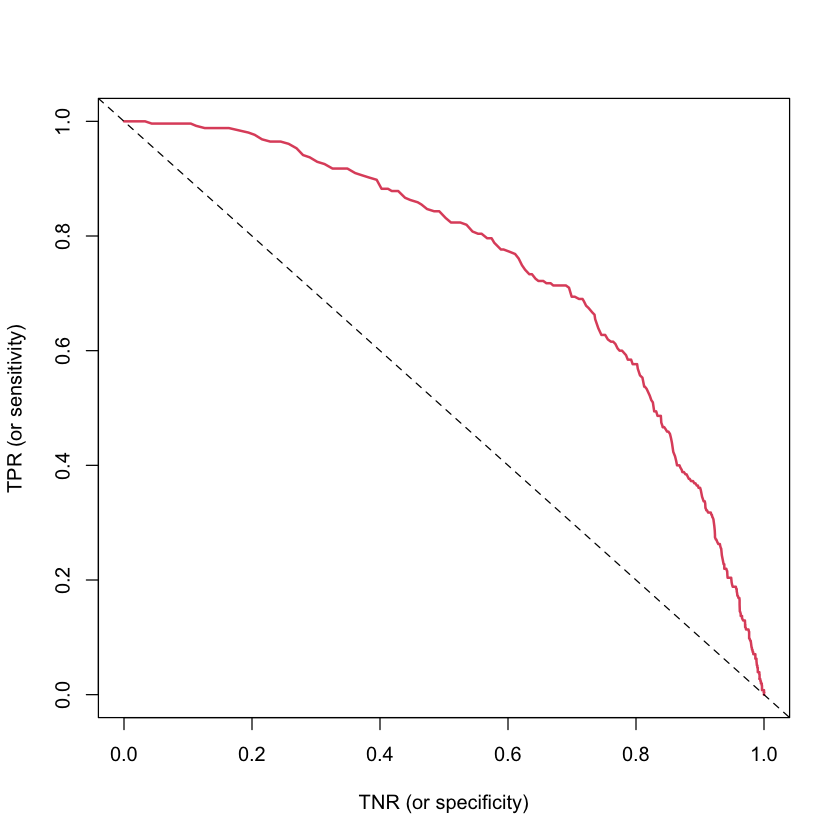

In [99]:
threshold <- seq(from = 0, to = 1, length = 999)
tp <- tn <- fp <- fn <- numeric(length(threshold))
for (i in seq_len(length(threshold))) {
  classes <- ifelse(prob > threshold[i], "yes", "no")
  tp[i] <- sum(classes == "yes" & y == "yes")  # true positives
  tn[i] <- sum(classes == "no"  & y == "no")  # true negatives
  fp[i] <- sum(classes == "yes" & y == "no")  # false positives
  fn[i] <- sum(classes == "no"  & y == "yes")  # false negatives
}
tpr <- tp / (tp + fn)  # sensitivity
tnr <- tn / (tn + fp)  # specificity

# Plot ROC curve
plot(tnr, y = tpr, type = "l", col = 2, lwd = 2, xlab = "TNR (or specificity)", 
     ylab = "TPR (or sensitivity)")
abline(1, -1, lty = 2)

In [ ]:
# Can be useful to use a package sometimes (e.g., for computing are under the ROC curve; AKA AUROC or AUC)
plot(roc1 <- pROC::roc(y, predictor = prob))
roc1

# Compare to ROC curve from MARS fit
prob2 <- predict(lr.mars, newdata = na.omit(wcgs), type = "response")[, "yes"]
lines(roc2 <- pROC::roc(y, predictor = prob2), col = 2)
roc2

In [ ]:
#
# A calibration curve and lift chart are often more useful
#

In [ ]:
# Function to compute lift and cumulative gain charts
lift <- function(prob, y, pos.class = NULL, cumulative = TRUE) {
  if (!all(sort(unique(y)) == c(0, 1))) {
    if (is.null(pos.class)) {
      stop("A value for `pos.class` is required whenever `y` is not a 0/1 ",
           "outcome.", call. = FALSE)
    }
    y <- ifelse(y == pos.class, 1, 0)
  }
  ord <- order(prob, decreasing = TRUE)
  prob <- prob[ord]
  y <- y[ord]
  prop <- seq_along(y) / length(y)
  lift <- if (isTRUE(cumulative)) {
    cumsum(y)
  } else {
    (cumsum(y) / seq_along(y)) / mean(y)
  }
  structure(list("lift" = lift, "prop" = prop, "cumulative" = cumulative,
                 "y" = y), class = "lift")
}

In [ ]:
# Cumulative gain chart; what does this plot tell us?
l <- lift(prob, y = y, pos.class = "yes")
plot(l[["prop"]], l[["lift"]], type = "l", 
     xlab = "Proportion of sample", ylab = "Cumulative lift", 
     las = 1, lwd = 2, col = 2)
abline(0, sum(wcgs$chd == "yes"), lty = 2)

# Compare to MARS fit
l2 <- lift(prob2, y = y, pos.class = "yes")
lines(l2[["prop"]], l2[["lift"]], col = 3)

In [ ]:
# Function to compute the Brier score; the Brier score is an example of a 
# *proper scoring rule* and is a better performance metric than AUROC when 
# probabilities are of interest (which they usually are)
brier.score <- function(y, prob) {  # this is a relative measure, like log loss/binomial deviance, SSE/RMSE, AIC/BIC, etc.
  mean((prob - y) ^ 2)  # y should be in {0, 1}
}

# Compute Brier score for previous models
y01 <- ifelse(y == "yes", 1, 0)
fit0 <- glm(chd ~ 1, data = na.omit(wcgs), family = binomial(link = "logit"))
brier.score(y01, prob = predict(fit0, type = "response"))
brier.score(y01, prob = predict(lr.fit.back, type = "response"))
brier.score(y01, prob = predict(lr.enet, newx = X, type = "response", s = "lambda.min")[, 1L, drop = TRUE])

In [100]:
# Same as Brier score for NULL (i.e., intercept-only) model
(p <- mean(wcgs$chd == "yes"))  # observed proportion of CHD in data
mean((p - y01) ^ 2)  # baseline Brier score for comparison

[1] 0.08148383

[1] 0.07461517

Dxy       C (ROC)            R2             D      D:Chi-sq 
 5.066096e-01  7.533048e-01  1.379163e-01  6.092631e-02  1.923086e+02 
          D:p             U      U:Chi-sq           U:p             Q 
           NA -6.369427e-04 -1.364242e-12  1.000000e+00  6.156326e-02 
        Brier     Intercept         Slope          Emax           E90 
 6.982106e-02 -2.441921e-15  1.000000e+00  3.395212e-01  1.873679e-02 
         Eavg           S:z           S:p 
 8.558448e-03  2.495997e-01  8.028969e-01

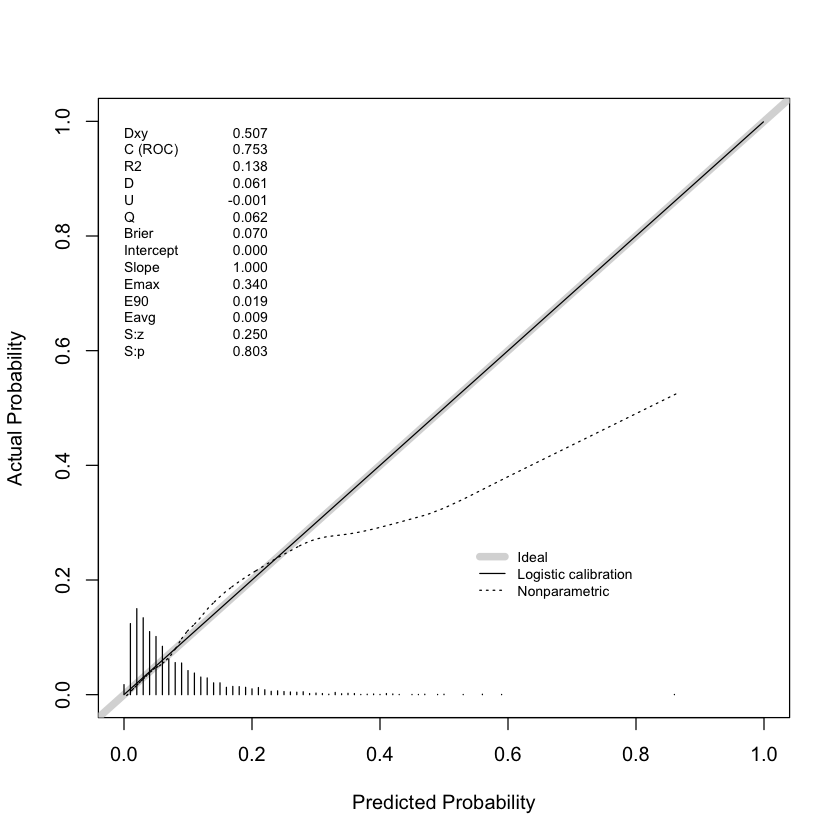

In [101]:
# Let's also look at a calibration curve; what does this plot tell us?
#
# Defn: A predictive model is said to be well-calibrated if its predictions 
# match the observed distributions in the data; that is, that a fraction of 
# about p of the events we predict with probability p actually occur.
#
# Calibration plots should become standard practice for all probability models
# (looking specifically at you, Machine Learning!)
#
# Some useful resources on calibration:
#
# * https://scikit-learn.org/stable/modules/calibration.html
# * https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf
# * https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Beyond-sigmoids--How-to-obtain-well-calibrated-probabilities-from/10.1214/17-EJS1338SI.full
# * Pretty much anything Frank Harrell says about calibration... try googling "Frank Harrell calibration"
#
# Fun fact: I did my dissertation on calibration in regression (related, but entirely different application)
# Topics in Statistical Calibration: https://apps.dtic.mil/sti/pdfs/ADA598921.pdf
rms::val.prob(prob, y = y01)

In [ ]:
# Check calibration of MARS model
rms::val.prob(prob2, y = y01)

In [ ]:
# Check calibration of ENET model
prob3 <- predict(lr.enet, newx = X, type = "response", s = "lambda.min")[, 1L, drop = TRUE]
rms::val.prob(prob3, y = y01)

In [ ]:
# Role your own solution using *regression splines*
temp <- data.frame("y" = y, "p" = prob)
cal <- glm(y ~ splines::ns(p, df = 6), data = temp,
           family = binomial(link = "logit"))

# Plot the results
xx <- seq(min(prob), max(prob), length = 200)
yy <- predict(cal, newdata = data.frame(p = xx), type = "response")
xx <- xx[!is.na(yy)]
yy <- yy[!is.na(yy)]
plot(xx, yy, xlim = c(0, 1), ylim = c(0, 1), type = "l", col = 2,
     xlab = "Predicted probability",
     ylab = "Calibrated probability")
abline(0, 1, lty = 2)
rug(prob, col = adjustcolor(1, alpha.f = 0.2))

In [ ]:
# General conclusion(s):
#
# * A simpe additive logistic regression model (i.e., no fancy transformations or interaction effects)
#   seems comparable (in terms of calibration and performance) to more complex logistic regresison models.